# Generate vehicle routing problem instance

In [1]:
import qiskit
print(qiskit.version.get_version_info())

2.1.1


In [2]:
import numpy as np

n = 4  # number of nodes + depot (n+1)
K = 2  # number of vehicles

# Get the data randomly placed nodes
class Initializer:
    def __init__(self, n):
        self.n = n

    def generate_instance(self):
        n = self.n

        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance
    
initializer = Initializer(n)
xc, yc, instance = initializer.generate_instance()

In [3]:
print(instance)

[[ 0.         36.84023052  5.061353   30.63150414]
 [36.84023052  0.         24.55322904 63.21893593]
 [ 5.061353   24.55322904  0.         15.49719877]
 [30.63150414 63.21893593 15.49719877  0.        ]]


# Functions to convert problem to QUBO


In [4]:
# from qiskit_optimization.problems.quadratic_program import QuadraticProgram
import networkx as nx
import itertools
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.problems import QuadraticProgram


def vehicle_routing_to_quadratic_program(graph: nx.Graph, depot: int, num_vehicles: int) -> QuadraticProgram:
    """
    Convert a vehicle routing problem instance into a QuadraticProgram.

    Args:
        graph: A networkx graph with edge weights representing distances or costs.
        depot: The index of the depot node.
        num_vehicles: The number of vehicles available.

    Returns:
        A QuadraticProgram representing the vehicle routing problem.
    """
    mdl = Model(name="Vehicle routing")
    n = graph.number_of_nodes()
    x = {}

    # Binary variables: x_ij = 1 if vehicle goes from node i to node j
    for i in range(n):
        for j in range(n):
            if i != j:
                x[(i, j)] = mdl.binary_var(name=f"x_{i}_{j}")

    # Objective: Minimize total travel cost
    mdl.minimize(
        mdl.sum(
            graph.edges[i, j]["weight"] * x[(i, j)]
            for i in range(n)
            for j in range(n)
            if i != j
        )
    )

    # Each node (except depot) has one outgoing and one incoming edge
    for i in range(n):
        if i != depot:
            mdl.add_constraint(mdl.sum(x[i, j] for j in range(n) if i != j) == 1)
    for j in range(n):
        if j != depot:
            mdl.add_constraint(mdl.sum(x[i, j] for i in range(n) if i != j) == 1)

    # Depot constraints: exactly num_vehicles enter and leave
    mdl.add_constraint(
        mdl.sum(x[i, depot] for i in range(n) if i != depot) == num_vehicles
    )
    mdl.add_constraint(
        mdl.sum(x[depot, j] for j in range(n) if j != depot) == num_vehicles
    )

    # Sub-tour elimination (using clique constraints)
    node_list = [i for i in range(n) if i != depot]
    for i in range(2, len(node_list) + 1):
        for clique in itertools.combinations(node_list, i):
            mdl.add_constraint(
                mdl.sum(x[i, j] for i in clique for j in clique if i != j) <= len(clique) - 1
            )

    # Convert to QuadraticProgram
    qp = from_docplex_mp(mdl)
    return qp


def vehicle_routing_to_objective(graph: nx.Graph, depot: int, num_vehicles: int) -> QuadraticProgram:
    mdl = Model(name="Vehicle routing obj")
    n = graph.number_of_nodes()
    x = {}
    # Binary variables: x_ij = 1 if vehicle goes from node i to node j
    for i in range(n):
        for j in range(n):
            if i != j:
                x[(i, j)] = mdl.binary_var(name=f"x_{i}_{j}")
    # Objective: Minimize total travel cost
    mdl.minimize(
        mdl.sum(
            graph.edges[i, j]["weight"] * x[(i, j)]
            for i in range(n)
            for j in range(n)
            if i != j
        )
    )
    # Convert to QuadraticProgram
    qp = from_docplex_mp(mdl)
    return qp
    

# Constrained Linear Problem

In [5]:
import matplotlib.pyplot as plt

G = nx.Graph()

# Add nodes and edges from the distance matrix
num_nodes = instance.shape[0]
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):  # Avoid duplicate edges
        if instance[i, j] > 0:  # skip zero or invalid distances
            G.add_edge(i, j, weight=instance[i, j])

vrp3 = vehicle_routing_to_quadratic_program(G, depot=0, num_vehicles=K)
# q3 = vrp3.to_quadratic_program()
print(vrp3.prettyprint())

Problem name: Vehicle routing

Minimize
  36.840230524848785*x_0_1 + 5.061352996006702*x_0_2 + 30.631504139776087*x_0_3
  + 36.840230524848785*x_1_0 + 24.553229038971544*x_1_2
  + 63.21893592648173*x_1_3 + 5.061352996006702*x_2_0 + 24.553229038971544*x_2_1
  + 15.497198766817078*x_2_3 + 30.631504139776087*x_3_0
  + 63.21893592648173*x_3_1 + 15.497198766817078*x_3_2

Subject to
  Linear constraints (8)
    x_1_0 + x_1_2 + x_1_3 == 1  'c0'
    x_2_0 + x_2_1 + x_2_3 == 1  'c1'
    x_3_0 + x_3_1 + x_3_2 == 1  'c2'
    x_0_1 + x_2_1 + x_3_1 == 1  'c3'
    x_0_2 + x_1_2 + x_3_2 == 1  'c4'
    x_0_3 + x_1_3 + x_2_3 == 1  'c5'
    x_1_0 + x_2_0 + x_3_0 == 2  'c6'
    x_0_1 + x_0_2 + x_0_3 == 2  'c7'

  Binary variables (12)
    x_0_1 x_0_2 x_0_3 x_1_0 x_1_2 x_1_3 x_2_0 x_2_1 x_2_3 x_3_0 x_3_1 x_3_2



## To QUBO

In [6]:
from qiskit_optimization.converters import QuadraticProgramToQubo

# conv = QuadraticProgramToQubo()
conv = QuadraticProgramToQubo(penalty=np.sum(instance)*2)    # ..............PENALTY............
qubo_with_constraints = conv.convert(vrp3)
print(qubo_with_constraints.export_as_lp_string())


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Vehicle routing

Minimize
 obj: - 4182.418602904797 x_0_1 - 4214.197480433639 x_0_2
      - 4188.627329289870 x_0_3 - 4182.418602904797 x_1_0
      - 2788.285993247459 x_1_2 - 2749.620286359949 x_1_3
      - 4214.197480433639 x_2_0 - 2788.285993247459 x_2_1
      - 2797.342023519614 x_2_3 - 4188.627329289870 x_3_0
      - 2749.620286359949 x_3_1 - 2797.342023519614 x_3_2 + [
      2812.839222286430 x_0_1^2 + 2812.839222286430 x_0_1*x_0_2
      + 2812.839222286430 x_0_1*x_0_3 + 2812.839222286430 x_0_1*x_2_1
      + 2812.839222286430 x_0_1*x_3_1 + 2812.839222286430 x_0_2^2
      + 2812.839222286430 x_0_2*x_0_3 + 2812.839222286430 x_0_2*x_1_2
      + 2812.839222286430 x_0_2*x_3_2 + 2812.839222286430 x_0_3^2
      + 2812.839222286430 x_0_3*x_1_3 + 2812.839222286430 x_0_3*x_2_3
      + 2812.839222286430 x_1_0^2 + 2812.839222286430 x_1_0*x_1_2
      + 2812.839222286430 x_1_0*x_1_3 + 2812.839222286430 x_1_0*x_2_0
 

In [7]:
print(qubo_with_constraints._objective._linear.to_dict(), "\n")
print(qubo_with_constraints._objective._quadratic.to_dict())

{0: -4182.418602904797, 1: -4214.197480433639, 2: -4188.6273292898695, 3: -4182.418602904797, 4: -2788.285993247459, 5: -2749.6202863599488, 6: -4214.197480433639, 7: -2788.285993247459, 8: -2797.3420235196136, 9: -4188.6273292898695, 10: -2749.6202863599488, 11: -2797.3420235196136} 

{(0, 0): 1406.4196111432152, (0, 1): 1406.4196111432152, (0, 2): 1406.4196111432152, (0, 7): 1406.4196111432152, (0, 10): 1406.4196111432152, (1, 1): 1406.4196111432152, (1, 2): 1406.4196111432152, (1, 4): 1406.4196111432152, (1, 11): 1406.4196111432152, (2, 2): 1406.4196111432152, (2, 5): 1406.4196111432152, (2, 8): 1406.4196111432152, (3, 3): 1406.4196111432152, (3, 4): 1406.4196111432152, (3, 5): 1406.4196111432152, (3, 6): 1406.4196111432152, (3, 9): 1406.4196111432152, (4, 4): 1406.4196111432152, (4, 5): 1406.4196111432152, (4, 11): 1406.4196111432152, (5, 5): 1406.4196111432152, (5, 8): 1406.4196111432152, (6, 6): 1406.4196111432152, (6, 7): 1406.4196111432152, (6, 8): 1406.4196111432152, (6, 9): 1

In [8]:
Q = qubo_with_constraints.objective.quadratic.to_array()

# Simplify diagonal terms: x^2 = x
linear = qubo_with_constraints.objective.linear.to_array()
diag = np.diag(Q)

# Update linear: x^2 term becomes x
simplified_linear = linear + diag

# Zero out the diagonal in the quadratic matrix
np.fill_diagonal(Q, 0)

# Optional: print simplified objective
print("Simplified linear:", simplified_linear)
print("Simplified quadratic (off-diagonal):\n", Q)

Simplified linear: [-2775.99899176 -2807.77786929 -2782.20771815 -2775.99899176
 -1381.8663821  -1343.20067522 -2807.77786929 -1381.8663821
 -1390.92241238 -2782.20771815 -1343.20067522 -1390.92241238]
Simplified quadratic (off-diagonal):
 [[   0.         1406.41961114 1406.41961114    0.            0.
     0.            0.         1406.41961114    0.            0.
  1406.41961114    0.        ]
 [   0.            0.         1406.41961114    0.         1406.41961114
     0.            0.            0.            0.            0.
     0.         1406.41961114]
 [   0.            0.            0.            0.            0.
  1406.41961114    0.            0.         1406.41961114    0.
     0.            0.        ]
 [   0.            0.            0.            0.         1406.41961114
  1406.41961114 1406.41961114    0.            0.         1406.41961114
     0.            0.        ]
 [   0.            0.            0.            0.            0.
  1406.41961114    0.            0. 

In [9]:
def build_qubo_from_arrays(linear, quadratic, variable_names=None):
    n = len(linear)
    qp = QuadraticProgram()
    
    # If variable names are not given, create default names
    if variable_names is None:
        variable_names = [f'x{i}' for i in range(n)]
    
    # Add binary variables
    for name in variable_names:
        qp.binary_var(name._name)
    
    # Add objective: minimize linear + quadratic terms
    linear_dict = {variable_names[i]._name: linear[i] for i in range(n)}
    
    # Only use upper triangle of Q to avoid double-counting
    quadratic_dict = {}
    for i in range(n):
        for j in range(i + 1, n):
            if quadratic[i, j] != 0:
                quadratic_dict[(variable_names[i]._name, variable_names[j]._name)] = quadratic[i, j]
   
    # Normalize coefficients
    max_lin_coeff = max(abs(v) for v in linear_dict.values())
    max_quad_coeff = max(abs(v) for v in quadratic_dict.values())

    if max_lin_coeff > max_quad_coeff:
        linear_dict_normed = {k: v / max_lin_coeff for k, v in linear_dict.items()}
        quadratic_dict_normed = {k: v / max_lin_coeff for k, v in quadratic_dict.items()}
    else:
        linear_dict_normed = {k: v / max_quad_coeff for k, v in linear_dict.items()}
        quadratic_dict_normed = {k: v / max_quad_coeff for k, v in quadratic_dict.items()} 
       
    qp.minimize(linear=linear_dict_normed, quadratic=quadratic_dict_normed)
    
    return qp

In [10]:
qubo_simple = build_qubo_from_arrays(simplified_linear, Q, variable_names=qubo_with_constraints.variables)
print(qubo_simple.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 0.988681840584 x_0_1 - x_0_2 - 0.990893100404 x_0_3
      - 0.988681840584 x_1_0 - 0.492156590170 x_1_2 - 0.478385662166 x_1_3
      - x_2_0 - 0.492156590170 x_2_1 - 0.495381927320 x_2_3
      - 0.990893100404 x_3_0 - 0.478385662166 x_3_1 - 0.495381927320 x_3_2 + [
      1.001802618737 x_0_1*x_0_2 + 1.001802618737 x_0_1*x_0_3
      + 1.001802618737 x_0_1*x_2_1 + 1.001802618737 x_0_1*x_3_1
      + 1.001802618737 x_0_2*x_0_3 + 1.001802618737 x_0_2*x_1_2
      + 1.001802618737 x_0_2*x_3_2 + 1.001802618737 x_0_3*x_1_3
      + 1.001802618737 x_0_3*x_2_3 + 1.001802618737 x_1_0*x_1_2
      + 1.001802618737 x_1_0*x_1_3 + 1.001802618737 x_1_0*x_2_0
      + 1.001802618737 x_1_0*x_3_0 + 1.001802618737 x_1_2*x_1_3
      + 1.001802618737 x_1_2*x_3_2 + 1.001802618737 x_1_3*x_2_3
      + 1.001802618737 x_2_0*x_2_1 + 1.001802618737 x_2_0*x_2_3
      + 1.001802618737 x_2_0*x_3_0 + 1.001802618737 x_2_1

In [11]:
num_variables = 0
for nam in qubo_with_constraints.variables:
    num_variables +=1
    print(nam._name)


x_0_1
x_0_2
x_0_3
x_1_0
x_1_2
x_1_3
x_2_0
x_2_1
x_2_3
x_3_0
x_3_1
x_3_2


In [12]:
def calculate_cost(candidate_bitstring, A, Q):
    if isinstance(candidate_bitstring, str):
        # Convert string to array of ints
        x = np.array([int(bit) for bit in candidate_bitstring])
    elif isinstance(candidate_bitstring, np.ndarray):
        x = candidate_bitstring
    elif isinstance(candidate_bitstring, list):
        # Handle list of strings or ints
        if all(isinstance(bit, str) for bit in candidate_bitstring):
            x = np.array([int(bit) for bit in candidate_bitstring])
        else:
            x = np.array(candidate_bitstring)
    else:
        raise TypeError("Unsupported bitstring type. Must be str, list, or np.ndarray.")

    return x @ Q @ x + A @ x

In [13]:
ising_H = qubo_simple.to_ising()[0]
print(ising_H)

SparsePauliOp(['IIIIIIIIIIIZ', 'IIIIIIIIIIZI', 'IIIIIIIIIZII', 'IIIIIIIIZIII', 'IIIIIIIZIIII', 'IIIIIIZIIIII', 'IIIIIZIIIIII', 'IIIIZIIIIIII', 'IIIZIIIIIIII', 'IIZIIIIIIIII', 'IZIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIIIIIIZZ', 'IIIIIIIIIZIZ', 'IIIIZIIIIIIZ', 'IZIIIIIIIIIZ', 'IIIIIIIIIZZI', 'IIIIIIIZIIZI', 'ZIIIIIIIIIZI', 'IIIIIIZIIZII', 'IIIZIIIIIZII', 'IIIIIIIZZIII', 'IIIIIIZIZIII', 'IIIIIZIIZIII', 'IIZIIIIIZIII', 'IIIIIIZZIIII', 'ZIIIIIIZIIII', 'IIIZIIZIIIII', 'IIIIZZIIIIII', 'IIIZIZIIIIII', 'IIZIIZIIIIII', 'IIIZZIIIIIII', 'IZIIZIIIIIII', 'IZZIIIIIIIII', 'ZIZIIIIIIIII', 'ZZIIIIIIIIII'],
              coeffs=[-0.00656039+0.j, -0.00090131+0.j, -0.00545476+0.j, -0.00656039+0.j,
 -0.25482301+0.j, -0.26170848+0.j, -0.00090131+0.j, -0.25482301+0.j,
 -0.25321035+0.j, -0.00545476+0.j, -0.26170848+0.j, -0.25321035+0.j,
  0.12522533+0.j,  0.12522533+0.j,  0.12522533+0.j,  0.12522533+0.j,
  0.12522533+0.j,  0.12522533+0.j,  0.12522533+0.j,  0.12522533+0.j,
  0.12522533+0.j,  0.12522533+0.j,  0.1252

In [14]:
print(ising_H.to_matrix(sparse=False))

[[1.44009126+0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.45140942+0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.44009126+0.j ... 0.        +0.j
  0.        +0.j 0.        +0.j]
 ...
 [0.        +0.j 0.        +0.j 0.        +0.j ... 3.56711921+0.j
  0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  3.55580105+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j ... 0.        +0.j
  0.        +0.j 4.57072445+0.j]]


In [15]:
print(len(ising_H.paulis[0]))

12


# Create Dicke State

In [16]:
from qiskit.circuit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import RYGate

# from  https://github.com/OpenQuantumComputing/QAOA/blob/main/qaoa/initialstates/dicke_initialstate.py
class Dicke:
    def __init__(self, k, n):
        """
        Args:
            k (int): The Hamming weight of the Dicke states.
            n (int): The number of qubits.
        """
        self.k = k
        self.N_qubits = n
        self.circuit = None

    def create_circuit(self):
        """
        Circuit to prepare Dicke states, following the algorithm from https://arxiv.org/pdf/1904.07358.pdf.
        """
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)

        self.circuit.x(q[-self.k:])  # Initialize last k qubits to |1>

        for l in range(self.k + 1, self.N_qubits + 1)[::-1]:
            self.circuit.append(
                Dicke.getBlock1(self.N_qubits, self.k, l), range(self.N_qubits)
            )

        for l in range(2, self.k + 1)[::-1]:
            self.circuit.append(
                Dicke.getBlock2(self.N_qubits, self.k, l), range(self.N_qubits)
            )

        return self.circuit

    @staticmethod
    def getRYi(n):
        qc = QuantumCircuit(2)
        qc.cx(0, 1)
        theta = 2 * np.arccos(np.sqrt(1 / n))
        ry = RYGate(theta).control(1, ctrl_state="1")
        qc.append(ry, [1, 0])
        qc.cx(0, 1)
        return qc

    @staticmethod
    def getRYii(l, n):
        qc = QuantumCircuit(3)
        qc.cx(0, 2)
        theta = 2 * np.arccos(np.sqrt(l / n))
        ry = RYGate(theta).control(2, ctrl_state="11")
        qc.append(ry, [2, 1, 0])
        qc.cx(0, 2)
        return qc

    @staticmethod
    def getSCS(n, k):
        qc = QuantumCircuit(k + 1)
        qc.append(Dicke.getRYi(n), [k - 1, k])
        for l in range(2, k + 1):
            qc.append(Dicke.getRYii(l, n), [k - l, k - l + 1, k])
        return qc

    @staticmethod
    def getBlock1(n, k, l):
        qr = QuantumRegister(n)
        qc = QuantumCircuit(qr)
        first = l - k - 1
        last = n - l
        index = list(range(n))

        if first != 0:
            index = index[first:]
        if last != 0:
            index = index[:-last]

        qc.append(Dicke.getSCS(l, k), index)
        return qc

    @staticmethod
    def getBlock2(n, k, l):
        qr = QuantumRegister(n)
        qc = QuantumCircuit(qr)
        last = n - l
        index = list(range(n))
        if last != 0:
            index = index[:-last]
        qc.append(Dicke.getSCS(l, l - 1), index)
        return qc


In [17]:
def create_dicke_circuit(n, k):
    """
    Create a QuantumCircuit that prepares the Dicke state |D(n, k)>.
    Args:
        n (int): Number of qubits.
        k (int): Number of 1's (excitations).
    Returns:
        QuantumCircuit
    """
    dicke = Dicke(k, n)
    return dicke.create_circuit()

In [18]:
from qiskit.circuit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import RYGate

def fracAngle(l, n):
    return 2 * np.arccos(np.sqrt(l / n))

def SCS(m):
    qr = QuantumRegister(m)
    qc = QuantumCircuit(qr)
    qc.ry(np.pi / 2, 1)
    qc.cx(1, 0)
    qc.ry(0.5 * fracAngle(m - 1, m), [0, 1])
    qc.cx(1, 0)
    qc.ry(-np.pi / 2, 1)
    for i in range(1, m - 1):
        qc.cx(i, i + 1)
        qc.ry(-0.25 * fracAngle(i + 1, m), i)
        qc.cx(i - 1, i)
        qc.ry(0.25 * fracAngle(i + 1, m), i)
        qc.cx(i + 1, i)
        qc.ry(-0.25 * fracAngle(i + 1, m), i)
        qc.cx(i - 1, i)
        qc.ry(0.25 * fracAngle(i + 1, m), i)
        qc.cx(i, i + 1)
    return qc

def DSU(m):
    qr = QuantumRegister(m)
    qc = QuantumCircuit(qr)
    for l in range(m, 1, -1):
        qc.compose(SCS(l), qubits=range(l), inplace=True)
    return qc

def short_depth_dicke_circuit(n, k):
    """Return a QuantumCircuit that prepares the Dicke state |D^n_k⟩."""
    assert 0 <= k <= n, "Hamming weight k must satisfy 0 ≤ k ≤ n"
    
    # Create basis state |0^(n-k)1^k⟩
    qr = QuantumRegister(n, 'q')
    qc = QuantumCircuit(qr)
    for i in range(n - k, n):
        qc.x(i)
    
    # Apply Dicke State Unitary to distribute the 1s
    qc.compose(DSU(n), qubits=range(n), inplace=True)
    return qc


In [19]:
from qiskit.circuit.library import PhaseGate
from qiskit.circuit import Parameter

def grover_mixer_from_initial_state(initial_state: QuantumCircuit) -> QuantumCircuit:
    """
    Constructs a Grover mixer circuit for QAOA from a given initial state circuit.

    Args:
        initial_state (QuantumCircuit): A circuit that prepares the initial feasible superposition.

    Returns:
        QuantumCircuit: A parameterized Grover mixer circuit.
    """
    n_qubits = initial_state.num_qubits
    beta = Parameter('x_beta')

    # US^\dagger
    grover = initial_state.inverse()

    # X^n
    grover.x(range(n_qubits))

    # C^{n-1}Phase
    if n_qubits == 1:
        phase = PhaseGate(-beta)
    else:
        phase = PhaseGate(-beta).control(n_qubits - 1)
    grover.append(phase, grover.qubits)

    # X^n
    grover.x(range(n_qubits))

    # US
    grover.compose(initial_state, qubits=range(n_qubits), inplace=True)

    return grover

# GM-QAOA

In [20]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.primitives import BitArray
from qiskit.visualization import plot_histogram


num_qubits = len(ising_H.paulis[0])

In [21]:
# Short depth ansatz
# qc = short_depth_dicke_circuit(num_qubits, n+K-1)
# qc_mixer = grover_mixer_from_initial_state(qc.copy())

# circuit_s = QAOAAnsatz(cost_operator=ising_H, reps=8, initial_state=qc_s, mixer_operator=qc_mixer, flatten=True)
# circuit_s.measure_all()

# print(circuit_s.parameters)
# candidate_s = pm.run(circuit_s)
# print(candidate_s.count_ops())
# print(candidate_s.depth())

In [22]:
# QAOA ansatz with grover mixer for dicke state
qc = create_dicke_circuit(num_qubits, n+K-1)
qc_mixer = grover_mixer_from_initial_state(qc.copy())

from qiskit.circuit.library import QAOAAnsatz, qaoa_ansatz
circuit = QAOAAnsatz(cost_operator=ising_H, reps=8, initial_state=qc, mixer_operator=qc_mixer, flatten=True)
circuit.measure_all()
# circuit.draw('mpl', scale=0.4)

In [23]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3]), ParameterVectorElement(γ[4]), ParameterVectorElement(γ[5]), ParameterVectorElement(γ[6]), ParameterVectorElement(γ[7])])

## Dicke state circuit testing

In [24]:
# dicke1 = create_dicke_circuit(8, 3)
# dicke2 = short_depth_dicke_circuit(8,3)

# dicke1.measure_all()
# dicke2.measure_all()


# from qiskit.primitives import StatevectorSampler as SamplerSim

# samplersim = SamplerSim()


# pub= (dicke1, )
# job = samplersim.run([pub], shots=int(1e4))
# pub_result = job.result()[0]
# bitarray_or = pub_result.data['meas']


In [25]:
# import matplotlib
# matplotlib.rcParams.update({"font.size": 12})

# plt.figure(figsize=(14, 8)) 
# plt.bar(bitarray_or.get_counts().keys(),bitarray_or.get_counts().values())
# plt.xticks(rotation=-90)
# plt.show()

In [26]:
# pub= (dicke2, )
# job = samplersim.run([pub], shots=int(1e4))
# pub_result = job.result()[0]
# bitarray_or = pub_result.data['meas']

In [27]:
# plt.figure(figsize=(14, 8)) 
# plt.bar(bitarray_or.get_counts().keys(),bitarray_or.get_counts().values())
# plt.xticks(rotation=-90)
# plt.show()

In [28]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit import generate_preset_pass_manager

# service = QiskitRuntimeService(name="fcrc4_premium")
# backend = service.backend("ibm_fez")
# pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
# candidate_circuit = pm.run(circuit)

# two_qubit_gate_depth = candidate_circuit.depth(lambda x: x.operation.num_qubits == 2)
# print(two_qubit_gate_depth)

## Transpilation

In [29]:
from qiskit_aer import AerSimulator
from qiskit.transpiler import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(3, AerSimulator())
isa_circuit = pass_manager.run(circuit)
print(isa_circuit.count_ops())

OrderedDict([('cx', 2686), ('cu', 1734), ('rzz', 192), ('cry', 187), ('x', 117), ('rz', 96), ('measure', 12), ('mcphase', 8), ('barrier', 1)])


# Normal Dicke GM-QAOA

In [30]:
initial_gamma = np.pi
initial_beta = np.pi/2

init_params = [initial_gamma, initial_beta] * (len(circuit.parameters)//2)

# transform the observable defined on virtual qubits to an observable defined on all physical qubits
isa_hamiltonian = ising_H.apply_layout(isa_circuit.layout)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)
    params_list.append(params)


    return cost

In [31]:
%%time
from scipy.optimize import minimize
from qiskit_aer.primitives import EstimatorV2 as Estimator

objective_func_vals = [] # Global variable
params_list = []
# isa_circuit.remove_final_measurements()

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(isa_circuit, isa_hamiltonian, estimator),
    method="COBYQA",
    tol=1e-2,
)
print(result)

 message: The lower bound for the trust-region radius has been reached
 success: True
  status: 0
     fun: -0.47982197817091865
       x: [ 3.144e+00  1.570e+00 ...  3.142e+00  1.569e+00]
     nit: 38
   maxcv: 0.0
    nfev: 106
CPU times: user 1h 16min 9s, sys: 3.55 s, total: 1h 16min 13s
Wall time: 3min 4s


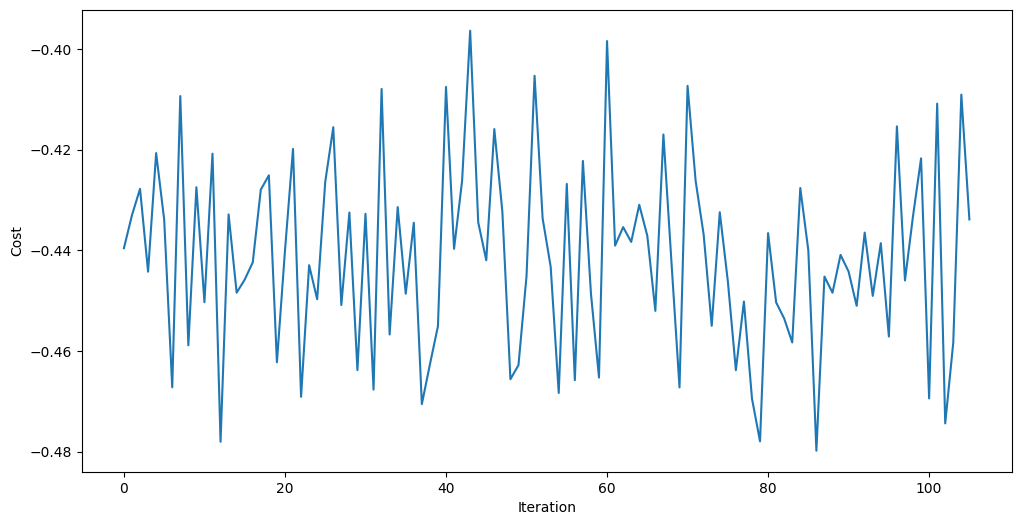

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [33]:
len(objective_func_vals)

106

In [34]:
optimized_circuit = isa_circuit.assign_parameters(result.x)
optimized_circuit.measure_all()

In [35]:
from qiskit_aer.primitives import SamplerV2 as Sampler

sampler = Sampler()

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

In [36]:
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_variables)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]


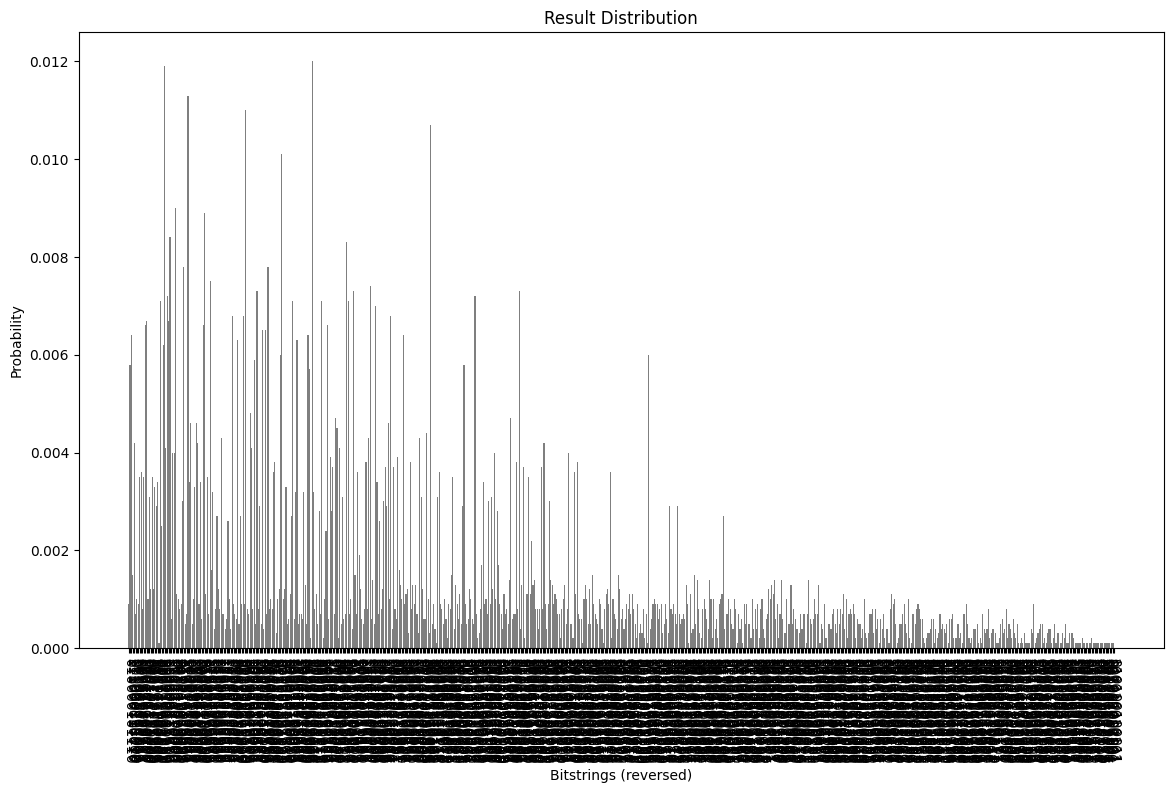

In [38]:
import matplotlib.pyplot as plt

final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
# for p in positions:
#     ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

## Plot the most frequent bit strings

In [39]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    # plt.axis("equal")
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color="r")
    plt.plot(xc[0], yc[0], "r*", ms=9)

    plt.grid()

    for ii in range(0, len(x)):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n

            plt.quiver(
                xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], 
                angles="xy", scale_units="xy", scale=1, color="b", width=0.005, headwidth=7, headlength=7)
    
    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()

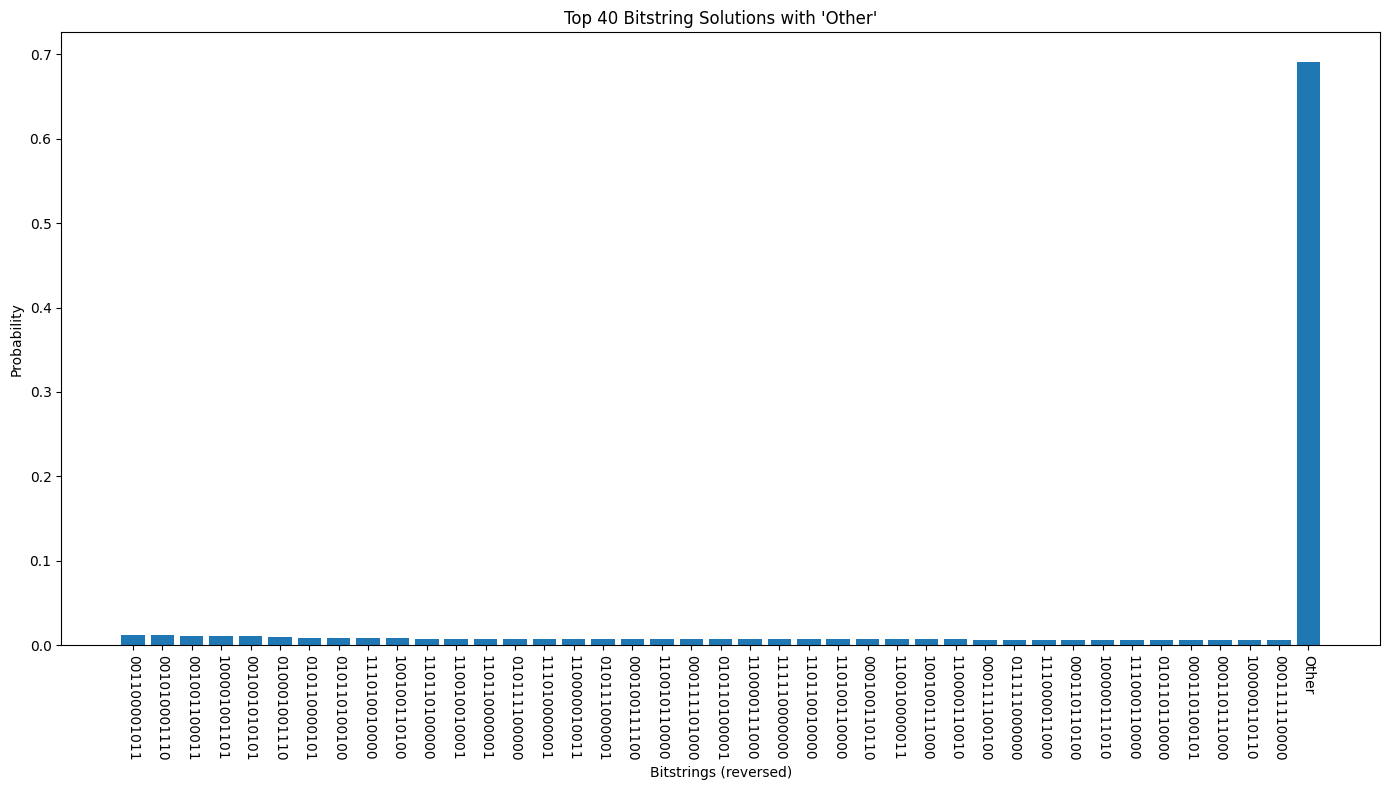

In [40]:
total = sum(final_bits.values())
normalized_bits = {k: v / total for k, v in final_bits.items()}

# Sort and extract top r values
r = 40
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_r = sorted_items[:r]
other_sum = sum(val for _, val in sorted_items[r:])

# Prepare labels and values
labels = [k for k, _ in top_r] + ["Other"]
values = [v for _, v in top_r] + [other_sum]

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Top {r} Bitstring Solutions with 'Other'")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(labels, values, color="tab:blue")

plt.tight_layout()
plt.show()

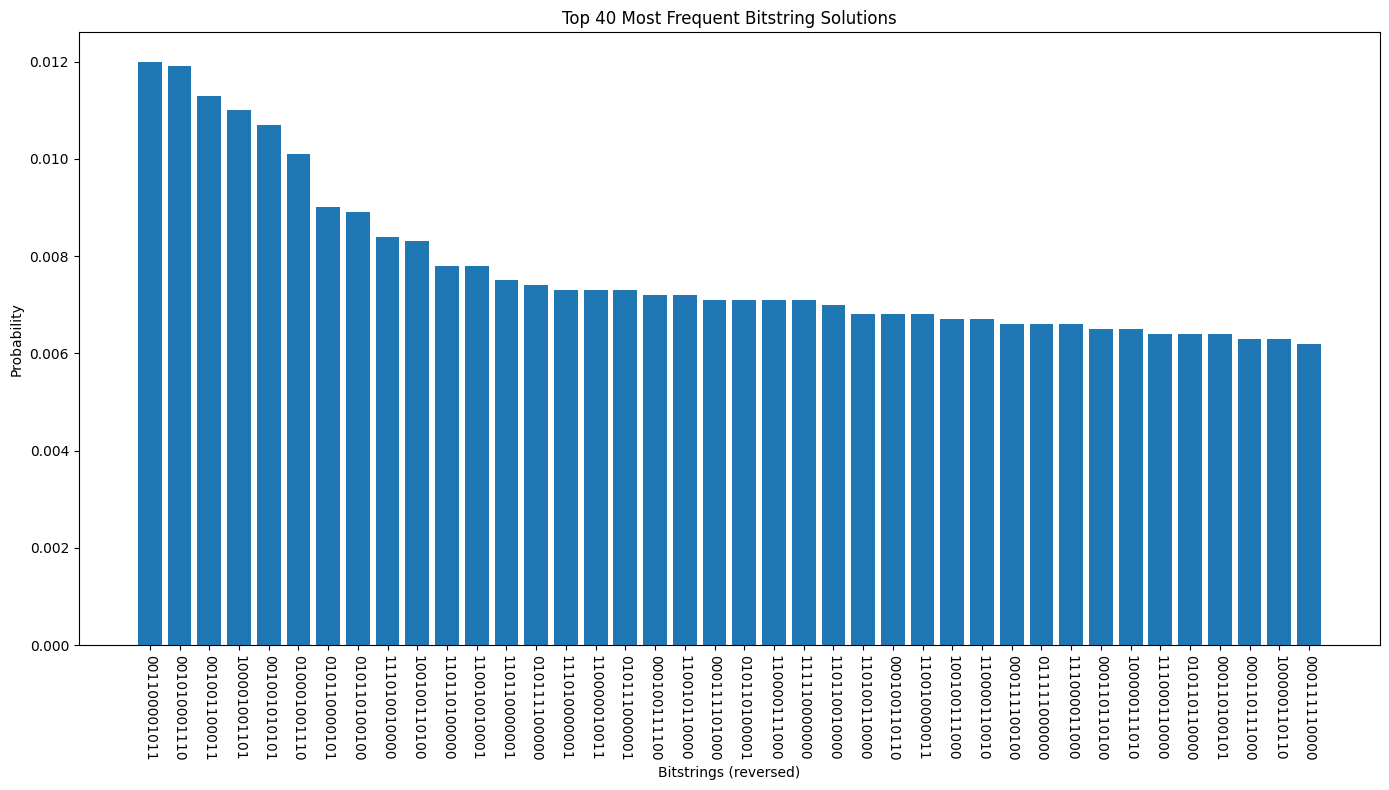

In [41]:
# Extract bitstrings and probabilities
labels = [k for k, _ in top_r]
values = [v for _, v in top_r]

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Top {r} Most Frequent Bitstring Solutions")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(labels, values, color="tab:blue")

plt.tight_layout()
plt.show()

[1 1 0 1 0 0 0 0 1 1 0 0]
[0 1 1 1 0 0 0 1 0 1 0 0]
[1 1 0 0 0 1 1 0 0 1 0 0]
[1 0 1 1 0 0 1 0 0 0 0 1]
[1 0 1 0 1 0 1 0 0 1 0 0]
[0 1 1 1 0 0 1 0 0 0 1 0]


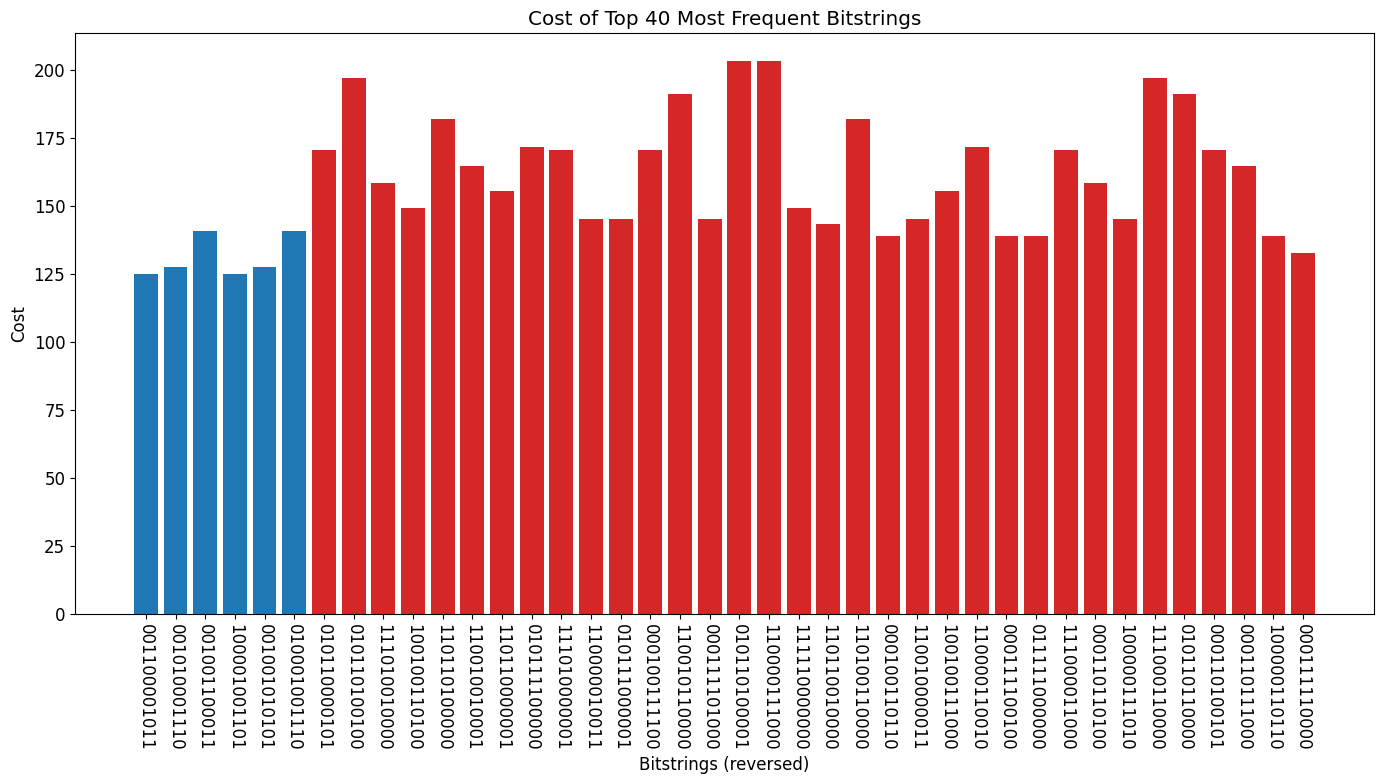

In [42]:
bitstrings = [k for k, _ in top_r]
costs = []
feasible_flags = []

for bs in bitstrings:
    x = np.array([int(b) for b in bs[-12:][::-1]])  # convert string to binary array
    costs.append(vrp3.objective.evaluate(x))
    feasible = vrp3.is_feasible(x)
    feasible_flags.append(feasible)
    if feasible:
        print(x)

# Plot
import matplotlib
matplotlib.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Cost of Top {r} Most Frequent Bitstrings")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Cost")

# Set bar colors based on feasibility
bar_colors = ["tab:blue" if f else "tab:red" for f in feasible_flags]
bars = ax.bar(bitstrings, costs, color=bar_colors)

plt.tight_layout()
plt.show()

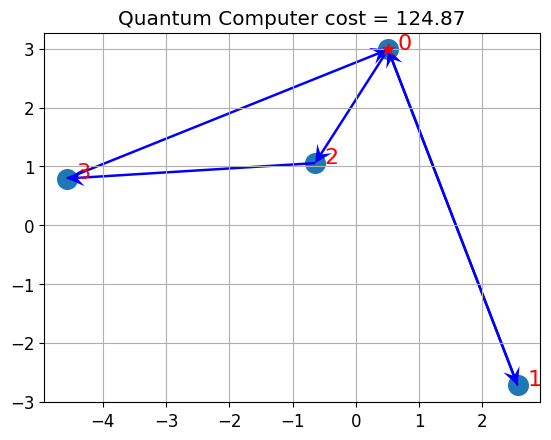

[1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]


In [43]:
# Put the solution in a way that is compatible with the classical variables
x_qc = np.zeros(n**2)
kk = 0
for ii in range(n**2):
    if ii // n != ii % n:
        x_qc[ii] = most_likely_bitstring[kk]
        kk += 1
  
qc_cost = vrp3.objective.evaluate([int(b) for b in most_likely_bitstring[:12]])

visualize_solution(xc, yc, x_qc, qc_cost, n, K, "Quantum Computer") 
print(most_likely_bitstring)

## Plot the top 20 most sampled solutions


 [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]


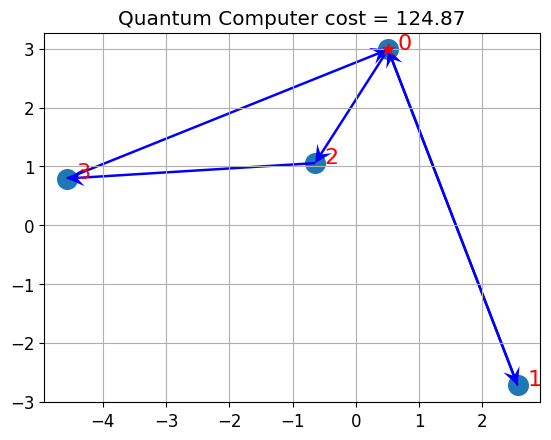


 [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]


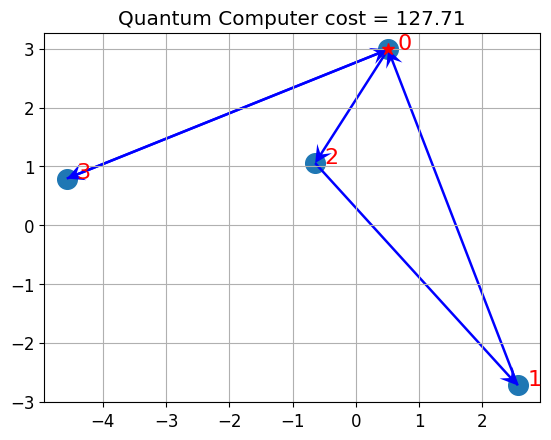


 [1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]


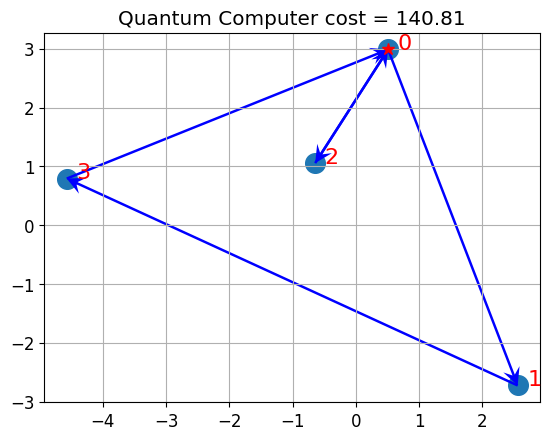


 [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1]


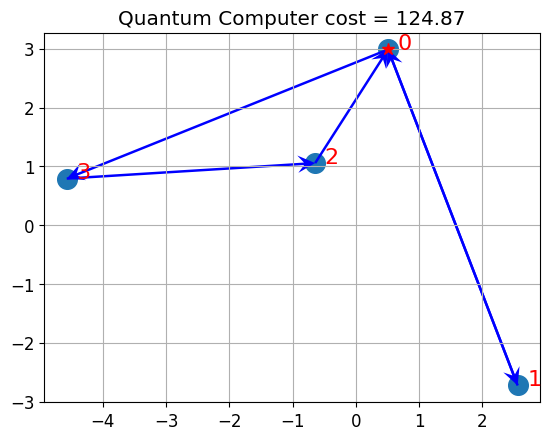


 [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]


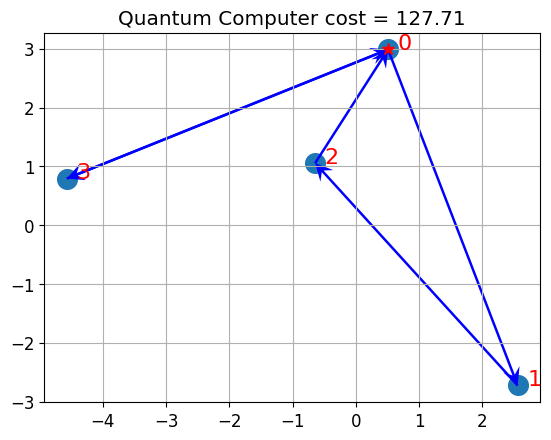


 [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0]


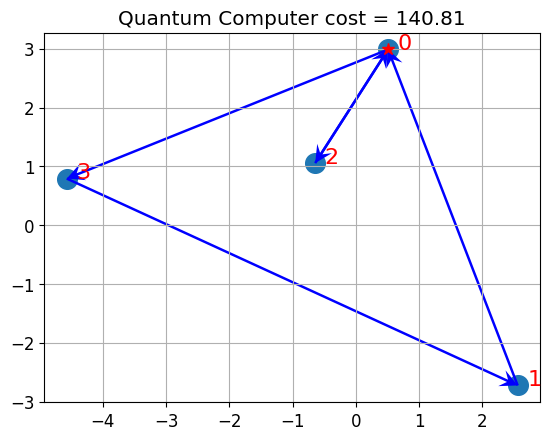


 [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


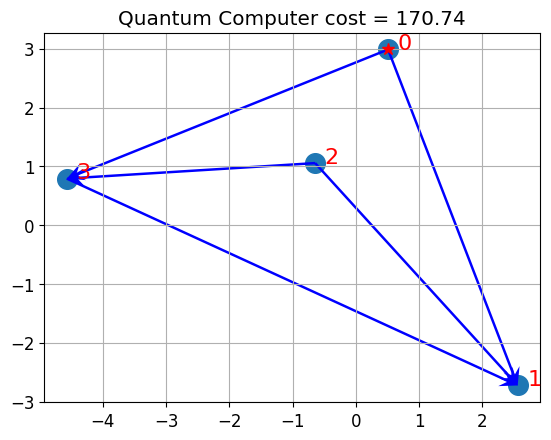


 [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]


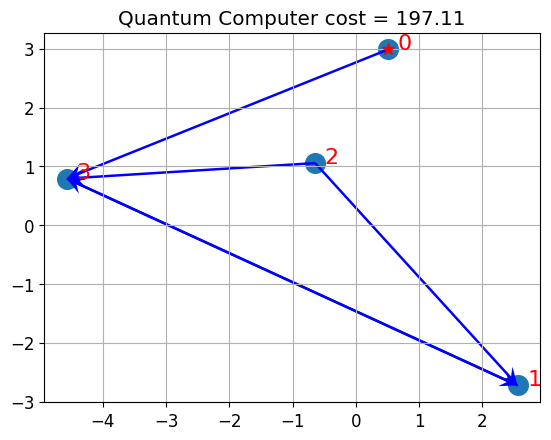


 [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]


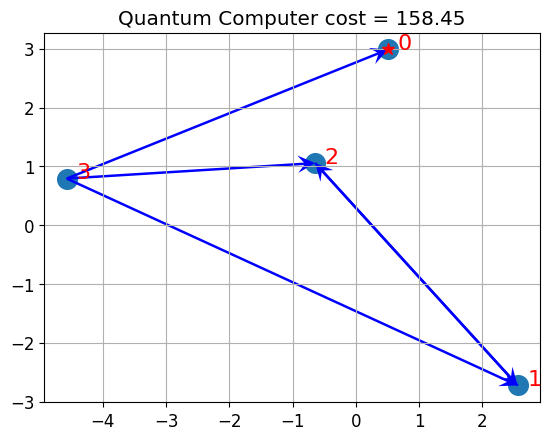


 [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]


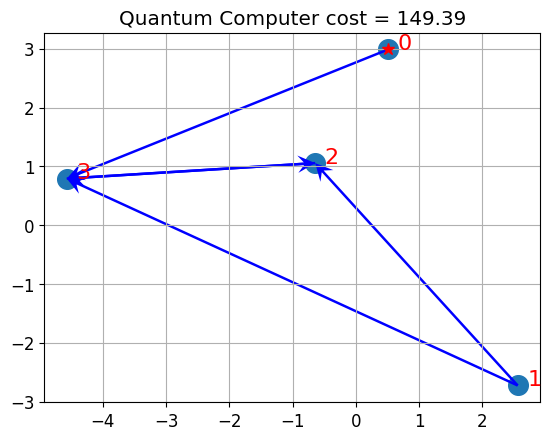


 [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1]


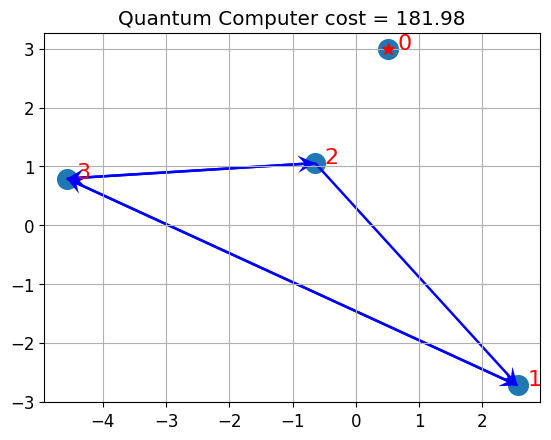


 [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]


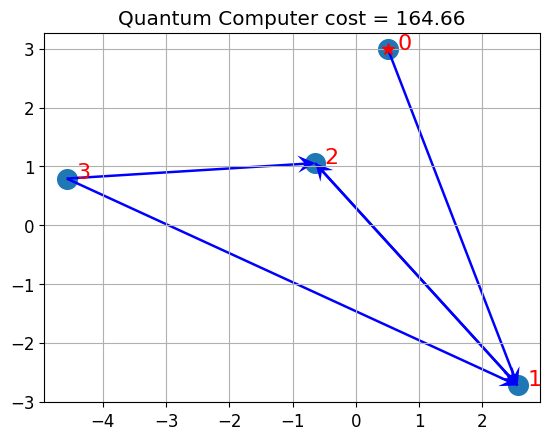


 [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]


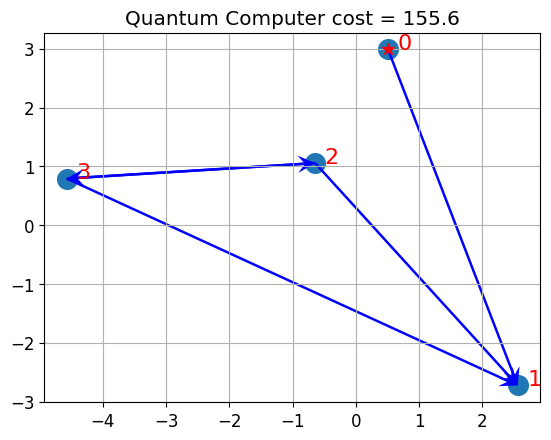


 [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0]


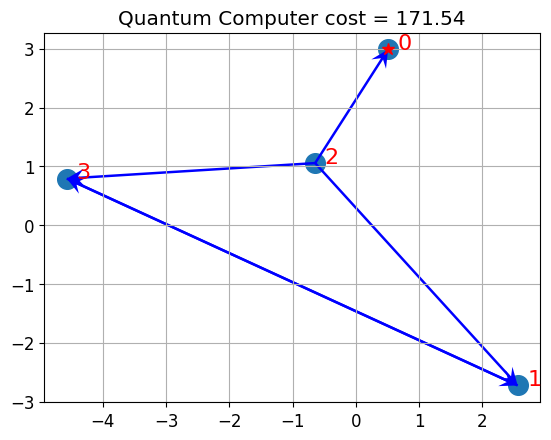


 [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1]


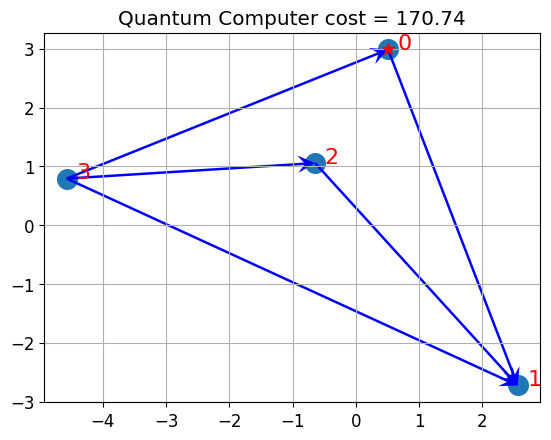


 [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]


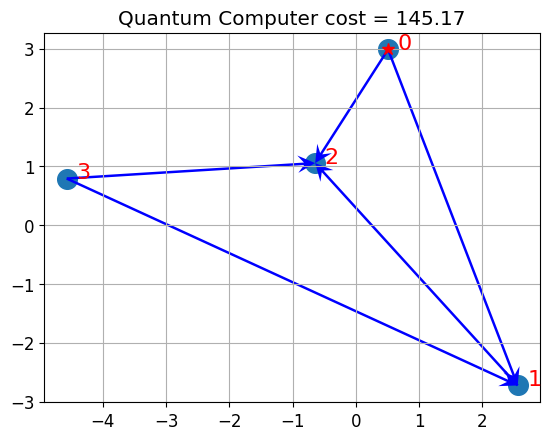


 [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]


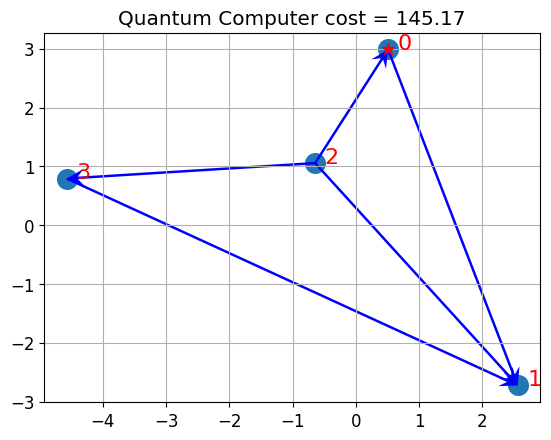


 [0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0]


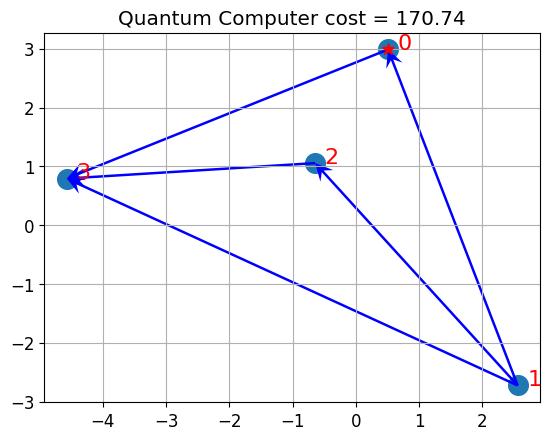


 [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]


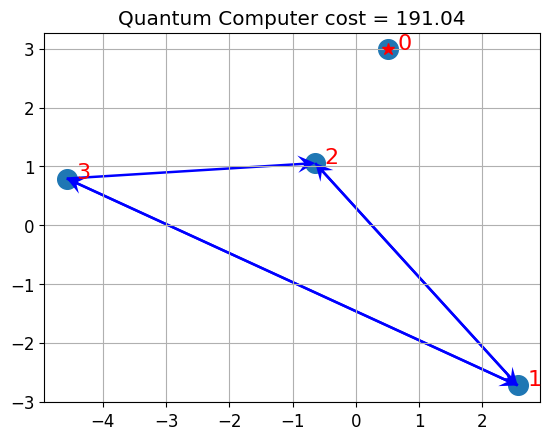


 [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]


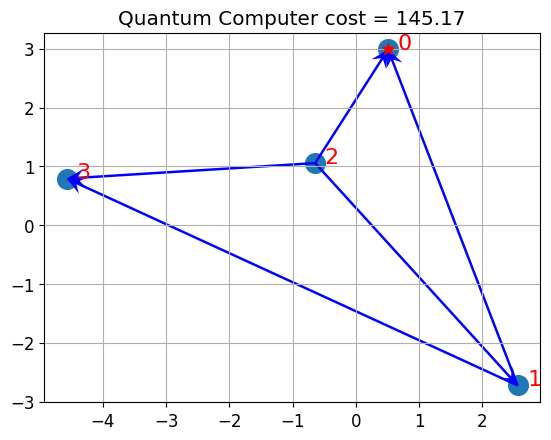

In [44]:
top_keys = bitstrings[:20]

for k in top_keys:
    # m = to_bitstring(k, num_variables)
    m = [int(b) for b in k[-12:][::-1]]
    # m.reverse()
    print("\n",m)
    x_qc = np.zeros(n**2)
    kk = 0
    for ii in range(n**2):
        if ii // n != ii % n:
            x_qc[ii] = m[kk]
            kk += 1

    qc_cost = vrp3.objective.evaluate([int(b) for b in m[:12]])
    visualize_solution(xc, yc, x_qc, qc_cost, n, K, "Quantum Computer") 

## Feasibility of top M bitstrings

In [48]:
M = 1000
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_M = sorted_items[:M]

bitstrings = [bs for bs, f in top_M]
freqs = [f for bs, f in top_M]

feasible_flags = []
feasible_freqs = []
idx=1
for bs, f in top_M:
    # convert string to binary array (last 12 bits, reversed)
    x = np.array([int(b) for b in bs[-12:][::-1]])
    feasible = vrp3.is_feasible(x)
    feasible_flags.append(feasible)
    
    if feasible:
        feasible_freqs.append(f)
        print(vrp3.objective.evaluate(x), idx)
    idx +=1

# Count feasible bitstrings
feasible_count = sum(feasible_flags)
fraction_feasible = feasible_count / M

# Weighted fraction by frequencies
total_freq = sum(freqs)
feasible_freq_sum = sum(feasible_freqs)
fraction_feasible_weighted = feasible_freq_sum / total_freq

print(f"Feasible (count): {feasible_count}/{M}")
print(f"Fraction feasible (count): {fraction_feasible:.2%}")
print(f"Fraction feasible (weighted by frequency): {fraction_feasible_weighted:.2%}")

124.87051695229744 1
127.7178208393792 2
140.81337658312 3
124.87051695229744 4
127.71782083937921 5
140.81337658312 6
Feasible (count): 6/1000
Fraction feasible (count): 0.60%
Fraction feasible (weighted by frequency): 6.70%


# Short depth Dicke GM-QAOA

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi/2

init_params = [initial_gamma, initial_beta] * (len(circuit_s.parameters)//2)

# transform the observable defined on virtual qubits to an observable defined on all physical qubits
isa_hamiltonian = ising_H.apply_layout(circuit_s.layout)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)
    params_list.append(params)

    return cost

In [ ]:
objective_func_vals = [] # Global variable
params_list = []
circuit_s.remove_final_measurements()

estimator = Estimator()

result = minimize(
    cost_func_estimator,
    init_params,
    args=(circuit_s, isa_hamiltonian, estimator),
    method="COBYLA",
    tol=1e-2,
)
print(result)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
optimized_circuit = circuit_s.assign_parameters(result.x)
optimized_circuit.measure_all()

In [ ]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

In [ ]:
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_variables)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

In [ ]:
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")

plt.show()

In [ ]:
total = sum(final_bits.values())
normalized_bits = {k: v / total for k, v in final_bits.items()}

# Sort and extract top r values
r = 40
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_r = sorted_items[:r]
other_sum = sum(val for _, val in sorted_items[r:])

# Prepare labels and values
labels = [k for k, _ in top_r] + ["Other"]
values = [v for _, v in top_r] + [other_sum]

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Top {r} Bitstring Solutions with 'Other'")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(labels, values, color="tab:blue")

plt.tight_layout()
plt.show()

In [ ]:
# Extract bitstrings and probabilities
labels = [k for k, _ in top_r]
values = [v for _, v in top_r]

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Top {r} Most Frequent Bitstring Solutions")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

bars = ax.bar(labels, values, color="tab:blue")

plt.tight_layout()
plt.show()

In [ ]:
bitstrings = [k for k, _ in top_r]

costs = []

feasible_flags = []
for bs in bitstrings:
    x = np.array([int(b) for b in bs[-12:][::-1]])  # convert string to binary array
    costs.append(vrp3.objective.evaluate(x))
    feasible = vrp3.is_feasible(x)
    feasible_flags.append(feasible)
    if feasible:
        print(x)

# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=-90)
plt.title(f"Cost of Top {r} Most Frequent Bitstrings")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Cost")

# Set bar colors based on feasibility
bar_colors = ["tab:blue" if f else "tab:red" for f in feasible_flags]
bars = ax.bar(bitstrings, costs, color=bar_colors)

plt.tight_layout()
plt.show()

In [ ]:
x_qc = np.zeros(n**2)
kk = 0
for ii in range(n**2):
    if ii // n != ii % n:
        x_qc[ii] = most_likely_bitstring[kk]
        kk += 1
  
qc_cost = vrp3.objective.evaluate([int(b) for b in most_likely_bitstring[:12]])

visualize_solution(xc, yc, x_qc, qc_cost, n, K, "Quantum Computer") 
print(most_likely_bitstring)

In [ ]:
top_keys = bitstrings[:20]

for k in top_keys:
    m = [int(b) for b in k[-12:][::-1]]
    # m.reverse()
    print("\n",m)
    x_qc = np.zeros(n**2)
    kk = 0
    for ii in range(n**2):
        if ii // n != ii % n:
            x_qc[ii] = m[kk]
            kk += 1

    qc_cost = vrp3.objective.evaluate([int(b) for b in m[:12]])
    visualize_solution(xc, yc, x_qc, qc_cost, n, K, "Quantum Computer") 

In [47]:
M = 1000
sorted_items = sorted(normalized_bits.items(), key=lambda x: x[1], reverse=True)
top_M = sorted_items[:M]

bitstrings = [bs for bs, f in top_M]
freqs = [f for bs, f in top_M]

feasible_flags = []
feasible_freqs = []
idx=1
for bs, f in top_M:
    # convert string to binary array (last 12 bits, reversed)
    x = np.array([int(b) for b in bs[-12:][::-1]])
    feasible = vrp3.is_feasible(x)
    feasible_flags.append(feasible)
    
    if feasible:
        feasible_freqs.append(f)
        print(vrp3.objective.evaluate(x), idx)
    idx +=1

# Count feasible bitstrings
feasible_count = sum(feasible_flags)
fraction_feasible = feasible_count / M

# Weighted fraction by frequencies
total_freq = sum(freqs)
feasible_freq_sum = sum(feasible_freqs)
fraction_feasible_weighted = feasible_freq_sum / total_freq

print(f"Feasible (count): {feasible_count}/{M}")
print(f"Fraction feasible (count): {fraction_feasible:.2%}")
print(f"Fraction feasible (weighted by frequency): {fraction_feasible_weighted:.2%}")

124.87051695229744 1
127.7178208393792 2
140.81337658312 3
124.87051695229744 4
127.71782083937921 5
140.81337658312 6
Feasible (count): 6/1000
Fraction feasible (count): 0.60%
Fraction feasible (weighted by frequency): 6.70%
